### `Step 1: Import Libraries and Download Historical Data`

We begin by importing the required libraries and downloading historical closing prices for SPY using `yfinance`. This will serve as the foundation for our backtest and simulations.


In [19]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

In [20]:
# Download historical data
ticker = 'SPY'
start_date = '2015-01-01'
end_date = '2025-05-31'
df = yf.download(ticker, start=start_date, end=end_date,multi_level_index=False)[["Close"]]
df.head()

/var/folders/jv/n757j32s0tlgz08bfwtb0k740000gn/T/ipykernel_1435/1364573561.py:5: FutureWarning:

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed


,Close
Date,
2015-01-02,171.567993
2015-01-05,168.469574
2015-01-06,166.882721
2015-01-07,168.962311
2015-01-08,171.960556


### `Step 2: Strategy Backtest`

We use a basic trend-following strategy: 
- Go **long** if the current price is above both its 10-day and 30-day moving averages.
- Stay **out** otherwise.

We then compute strategy returns by applying this rule across the price history.


In [21]:
# Calculate moving averages
df['MA_10'] = df['Close'].rolling(window=10).mean()
df['MA_30'] = df['Close'].rolling(window=30).mean()

# Generate signal: 1 if bullish, 0 otherwise
df['Signal'] = np.where((df['Close'] > df['MA_10']) & (df['Close'] > df['MA_30']), 1, 0)

# Calculate returns
df['Returns'] = df['Close'].pct_change()
df['Strategy_Returns'] = df['Signal'].shift(1) * df['Returns']

# Drop NA values due to moving average lag
df.dropna(inplace=True)


In [22]:
df.head()

,Close,MA_10,MA_30,Signal,Returns,Strategy_Returns
Date,,,,,,
2015-02-13,175.201065,172.007333,170.129042,1,0.004117,0.000000
2015-02-17,175.476608,172.691335,170.259329,1,0.001573,0.001573
2015-02-18,175.493332,173.133141,170.493454,1,0.000095,0.000095
2015-02-19,175.368057,173.627562,170.776299,1,-0.000714,-0.000714
2015-02-20,176.420380,174.055167,171.024901,1,0.006001,0.006001


### `Step 3: Visualizing Strategy Performance`

We convert strategy returns into a cumulative portfolio value and plot the performance using Plotly for interactive visualization.


In [23]:
# Set initial capital and compute cumulative portfolio value
initial_capital = 1000
df['Portfolio_Value'] = initial_capital * (1 + df['Strategy_Returns']).cumprod()


In [24]:
# Step 1: Calculate drawdown
df['Cumulative_Max'] = df['Portfolio_Value'].cummax()
df['Drawdown'] = (df['Portfolio_Value'] - df['Cumulative_Max']) / df['Cumulative_Max']

# Step 2: Create subplots with 2 rows
fig = make_subplots(
    rows=2, cols=1, 
    shared_xaxes=True,
    vertical_spacing=0.1,
    subplot_titles=('Strategy Portfolio Value', 'Drawdown')
)

# Step 3: Add portfolio value to first plot
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Portfolio_Value'], 
    mode='lines', 
    name='Portfolio Value'
), row=1, col=1)

# Step 4: Add drawdown to second plot
fig.add_trace(go.Scatter(
    x=df.index, 
    y=df['Drawdown'], 
    mode='lines', 
    name='Drawdown',
    line=dict(color='red')
), row=2, col=1)

# Step 5: Update layout
fig.update_layout(
    title='Single Backtest: Portfolio Value and Drawdown',
    height=1000,
    template='seaborn'
)

fig.update_yaxes(title_text="Portfolio Value ($)", row=1, col=1)
fig.update_yaxes(title_text="Drawdown (%)", row=2, col=1, tickformat=".0%")
fig.update_xaxes(title_text="Date", row=2, col=1)
fig.update_xaxes(showticklabels=True, row=1, col=1)

import plotly.io as pio
pio.renderers.default = 'browser'
fig.show()



In [25]:
# Cumulative returns and portfolio value
df['Cumulative_Returns'] = (1 + df['Strategy_Returns']).cumprod()
initial_capital = 100000
df['Portfolio_Value'] = initial_capital * df['Cumulative_Returns']

# Total return
total_return = (df['Portfolio_Value'].iloc[-1] / initial_capital - 1) * 100

# Annualized return
n_days = len(df)
annualized_return = df['Strategy_Returns'].mean() * 252 * 100

# Volatility
volatility = df['Strategy_Returns'].std() * np.sqrt(252) * 100

# Sharpe Ratio (assuming risk-free rate = 0)
sharpe_ratio = annualized_return/volatility

# Max drawdown
rolling_max = df['Portfolio_Value'].cummax()
drawdown = (df['Portfolio_Value'] - rolling_max) / rolling_max
max_drawdown = drawdown.min() * 100

# Print results
print(f"Total Return: {total_return:.2f}%")
print(f"Annualized Return: {annualized_return:.2f}%")
print(f"Annualized Volatility: {volatility:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")


Total Return: 96.57%
Annualized Return: 6.95%
Annualized Volatility: 8.66%
Sharpe Ratio: 0.80
Maximum Drawdown: -11.69%


### `Step 4: Converting Strategy Logic into a Function`

To enable reuse across multiple price series or simulations, we encapsulate the backtest logic in a function. 

This function:
- Accepts a price series and a starting capital.
- Applies the moving average crossover strategy.
- Returns the final portfolio value over time.


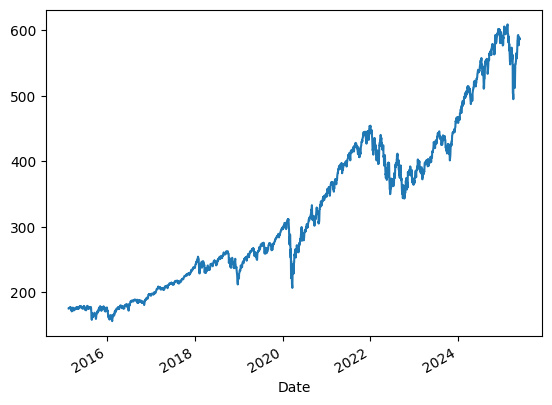

In [26]:
df.Close.plot();

In [27]:
def run_backtest(price_series, initial_capital=1000):
    df_bt = pd.DataFrame()
    df_bt['Close'] = price_series

    # Strategy logic
    df_bt['MA_10'] = df_bt['Close'].rolling(window=10).mean()
    df_bt['MA_30'] = df_bt['Close'].rolling(window=30).mean()
    df_bt['Signal'] = np.where((df_bt['Close'] > df_bt['MA_10']) & 
                               (df_bt['Close'] > df_bt['MA_30']), 1, 0)

    # Strategy returns
    df_bt['Returns'] = df_bt['Close'].pct_change()
    df_bt['Strategy_Returns'] = df_bt['Signal'].shift(1) * df_bt['Returns']

    df_bt.dropna(inplace=True)
    df_bt['Portfolio_Value'] = initial_capital * (1 + df_bt['Strategy_Returns']).cumprod()

    return df_bt


### `Step 5: Simulating Alternate Price Paths Using Monte Carlo`

To explore how **path-dependent** our strategy is, we simulate alternative versions of the same asset using Monte Carlo techniques.

We'll use a **log-normal model** based on the historical return distribution of SPY to generate multiple price paths:
- Each path starts from the same initial price.
- Each follows a sequence of returns sampled from the historical return distribution (bootstrapping).
- We then run the **same strategy** on each simulated path to observe the variation in final outcomes.


In [28]:
log_returns = np.log(df['Close'] / df['Close'].shift(1)).dropna()

In [29]:
# Set number of paths and duration
num_paths = 5000
num_days = len(df)

# Get the last observed price as starting point
start_price = df['Close'].iloc[0]

# Generate price paths
simulated_paths = []

for _ in range(num_paths):
    sampled_returns = np.random.choice(log_returns, size=num_days, replace=True)
    path = start_price * np.exp(np.cumsum(sampled_returns))
    simulated_paths.append(path)


In [30]:
simulated_paths

[array([175.63641787, 176.10535808, 172.36397082, ..., 682.26454916,
        674.55221389, 672.68866259], shape=(2589,)),
 array([176.50257202, 176.51101979, 177.72493384, ..., 899.26239076,
        896.05395629, 884.07192765], shape=(2589,)),
 array([173.77353503, 177.14486635, 172.81160292, ..., 425.53602076,
        426.11832766, 425.90558794], shape=(2589,)),
 array([176.89678551, 177.27220971, 176.90979638, ..., 642.49866549,
        641.84374985, 634.3388723 ], shape=(2589,)),
 array([177.7117728 , 177.05497894, 174.24444666, ..., 644.81819457,
        645.57523026, 645.17502695], shape=(2589,)),
 array([175.45291704, 174.8611289 , 176.2459144 , ..., 574.75874979,
        576.78208406, 577.68248068], shape=(2589,)),
 array([174.16418947, 174.63964834, 175.86295465, ..., 707.77088219,
        705.35374281, 707.13148144], shape=(2589,)),
 array([172.8655526 , 171.72251326, 171.21881962, ..., 840.85314356,
        834.2537241 , 832.22892429], shape=(2589,)),
 array([175.79065509, 17

In [31]:
fig = go.Figure()

# Plot a sample of 100 paths for clarity
for path in simulated_paths[:200]:
    fig.add_trace(go.Scatter(
        y=path, mode='lines', line=dict(width=1), opacity=0.3, showlegend=False
    ))

fig.update_layout(
    # title='Monte Carlo Simulated Price Paths',
    xaxis_title='Days',
    yaxis_title='Simulated Price',
    template='presentation',
    height=500
)
fig.show()


### `Step 6: Apply the Strategy to Simulated Paths`

We now take each of the 5,000 Monte Carlo-simulated price paths and apply our trading strategy to them using the same logic as before.

This gives us a distribution of possible portfolio outcomes, allowing us to assess the **path dependence** of the strategy:
- If the results vary wildly, the strategy is highly path dependent.
- If they are consistent, the strategy is likely robust.


In [32]:
strategy_returns_list = []
final_values = []

for path in simulated_paths:
    bt = run_backtest(pd.Series(path))                            # using the same strategy function
    strategy_returns_list.append(bt['Portfolio_Value'].values)
    final_values.append(bt['Portfolio_Value'].iloc[-1])


### `Visualizing Strategy Outcomes Across Simulations`

We now visualize:
- A sample of the 5,000 portfolio value paths under the same strategy
- The original backtest result (in black) for comparison


In [33]:
fig = go.Figure()

# Plot subset of strategy return paths
for sim in strategy_returns_list[:400]:
    fig.add_trace(go.Scatter(
        y=sim/1000, 
        mode='lines',
        line=dict(width=0.8),
        opacity=0.3,
        showlegend=False
    ))

# Overlay original backtest result
fig.add_trace(go.Scatter(
    y=df['Portfolio_Value'].values/100000,
    mode='lines',
    line=dict(color='black', width=2.5),
    name='Original Backtest'
))

fig.update_layout(
    title='Monte Carlo Simulations vs Original Strategy Path',
    xaxis_title='Days',
    yaxis_title='Normalized Portfolio Value',
    template='seaborn',
    height=600
)
fig.show()


### `Distribution of Final Portfolio Values`

Let’s now look at the distribution of **final returns** from all the simulations to get a probabilistic sense of strategy performance.


In [34]:
initial_capital = 1000
total_returns = [(final - initial_capital) / initial_capital * 100 for final in final_values]
percentiles = [5, 25, 50, 75, 95]
percentile_values = np.percentile(total_returns, percentiles)


In [35]:
fig = go.Figure()

fig.add_trace(go.Histogram(
    x=total_returns,
    nbinsx=400,
    marker=dict(color='lightblue', line=dict(color='black', width=1)),
    opacity=0.85
))

# Add vertical percentile lines
colors = ['red', 'orange', 'green', 'orange', 'red']
for i, perc in enumerate(percentiles):
    fig.add_shape(
        type='line',
        x0=percentile_values[i], x1=percentile_values[i],
        y0=0, y1=0.9,
        xref='x', yref='paper',
        line=dict(dash='dash', width=2, color=colors[i])
    )
    fig.add_annotation(
        x=percentile_values[i],
        y=0.95,
        text=f'{perc}th: {percentile_values[i]:.2f}%',
        showarrow=False,
        yref='paper'
    )

fig.update_layout(
    title='Distribution of Final Portfolio Returns from 5,000 Simulations',
    xaxis_title='Total Return (%)',
    yaxis_title='Frequency',
    template='seaborn',
    height=500
)
fig.show()


This distribution tells us how often the strategy succeeds or fails, even under plausible alternate realities. 

If the left tail is large, our strategy is **highly path dependent**- meaning a good outcome depends heavily on the market taking the "right" path.


| Percentile         | Meaning                                                         |
| ------------------ | --------------------------------------------------------------- |
| **5th (-10.48%)**  | Worst 5% of simulations ended below this value. 95% did better. |
| **25th (30.28%)**  | 25% of simulations ended below this return.                     |
| **50th (71.01%)**  | Median simulation: half performed better, half worse.          |
| **75th (128.40%)** | 25% of simulations exceeded this: strong right tail.           |
| **95th (251.47%)** | Top 5% of simulations gave greater than 2.5x return.            |


### `Step 7: Evaluating Risk and Return Quality Across Simulations`

To go beyond total returns, we now compute two key metrics for each of the 5,000 simulated strategy paths:

- **Maximum Drawdown**: The worst peak-to-trough drop - a measure of risk.
- **Sharpe Ratio**: Return per unit of volatility - a measure of risk-adjusted performance.

This allows us to answer:  
> "Does the strategy not only make money, but do so **consistently and without deep losses**?"


In [36]:
def calculate_max_drawdown(series):
    running_max = np.maximum.accumulate(series)
    drawdown = (series - running_max) / running_max
    return drawdown.min()

def calculate_sharpe_ratio(returns):
    ann_returns = returns.mean()*242
    ann_vol = returns.std()*np.sqrt(252)
    return ann_returns/ann_vol


In [37]:
max_drawdowns = []
sharpe_ratios = []

for sim_path in strategy_returns_list:
    portfolio_series = pd.Series(sim_path)

    # Calculate strategy returns from portfolio value
    strat_returns = portfolio_series.pct_change().dropna()

    # Append metrics
    max_drawdowns.append(calculate_max_drawdown(portfolio_series))
    sharpe_ratios.append(calculate_sharpe_ratio(strat_returns))


In [38]:
# Let's say this is the actual backtest drawdown from df
portfolio_max_drawdown = df['Drawdown'].min()

fig = go.Figure()

# Histogram of simulated max drawdowns
fig.add_trace(go.Histogram(
    x=max_drawdowns,
    nbinsx=400,
    marker=dict(color='salmon', line=dict(color='black', width=1)),
    opacity=0.85,
    name='Simulated Max Drawdowns'
))

# Vertical line for actual portfolio drawdown
fig.add_shape(
    type="line",
    x0=portfolio_max_drawdown, x1=portfolio_max_drawdown,
    y0=0, y1=1, yref='paper',
    line=dict(color="black", width=3, dash="dash"),
    name='Backtest Max Drawdown'
)

# Optional: Add annotation to explain the line
fig.add_annotation(
    x=portfolio_max_drawdown,
    y=1.05, yref='paper',
    text="Backtest Max Drawdown",
    showarrow=False,
    font=dict(color="black", size=12),
    align="center"
)

# Layout settings
fig.update_layout(
    title='Distribution of Maximum Drawdowns (5,000 Simulations)',
    xaxis_title='Max Drawdown (as a decimal)',
    yaxis_title='Frequency',
    template='seaborn',
    height=500
)

fig.show()


In [39]:
# Sharpe ratio from your backtest portfolio
backtest_sharpe = (df['Strategy_Returns'].mean()*252) / (df['Strategy_Returns'].std() * np.sqrt(252))

fig = go.Figure()

# Histogram of simulated Sharpe ratios
fig.add_trace(go.Histogram(
    x=sharpe_ratios,
    nbinsx=400,
    marker=dict(color='mediumseagreen', line=dict(color='black', width=1)),
    opacity=0.85,
    name='Simulated Sharpe Ratios'
))

# Vertical line for actual Sharpe ratio from backtest
fig.add_shape(
    type="line",
    x0=backtest_sharpe, x1=backtest_sharpe,
    y0=0, y1=1, yref='paper',
    line=dict(color="black", width=3, dash="dash"),
    name='Backtest Sharpe Ratio'
)

# Annotation for vertical line
fig.add_annotation(
    x=backtest_sharpe,
    y=1.05, yref='paper',
    text="Backtest Sharpe Ratio",
    showarrow=False,
    font=dict(color="black", size=12),
    align="center"
)

# Layout settings
fig.update_layout(
    title='Distribution of Sharpe Ratios (5,000 Simulations)',
    xaxis_title='Sharpe Ratio',
    yaxis_title='Frequency',
    template='seaborn',
    height=500
)

fig.show()


### Interpretation

- A **tight max drawdown distribution** with shallow values implies that the strategy rarely suffers severe losses.
- A **Sharpe ratio consistently above 1** across simulations means the strategy not only performs well: it does so with strong risk-adjusted consistency.

Together, these distributions give us a well-rounded picture of how the strategy performs **not just on average, but across different simulated realities** - balancing upside, downside, and volatility.
